VariantSpark no hail demo
=====================================

- Initialising the spark context
- Importing features and labels
- Converting features to a pandas DataFrame
- Fitting a model
- Exporting the fitted model to .json (in batches)
- Returning the model's out-of-bag error
- Running importance analyses
- Calculating and analysing local FDR
- Manhattan plotting variable importances using FDR derived p-values

Creating a spark session with VariantSpark jar attached.

In [1]:
import varspark as vs
from pyspark.sql import SparkSession
cluster = False
if not cluster:
    spark = SparkSession.builder.config('spark.jars', vs.find_jar()).getOrCreate()
else:
    spark = SparkSession.builder.config('spark.jars', vs.find_jar()).master('spark://RADON-BH.nexus.csiro.au:7077').getOrCreate()
import matplotlib.pyplot as plt
vc = vs.VarsparkContext(spark, silent=True)

24/09/19 14:07:43 WARN Utils: Your hostname, RADON-BH resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/19 14:07:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/09/19 14:07:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Loading features and labels

In [2]:
genotypes = vc.import_vcf('../../data/hipsterIndex/hipster.vcf')
labels = vc.load_label('../../data/hipsterIndex/hipster_labels.txt', 'label')
covtypes = {
    "score": "CONTINUOUS",
    "label": "ORDINAL(2)",
    "age": "CONTINUOUS",
    "PC0": "CONTINUOUS",
    "PC1": "CONTINUOUS",
    "PC2": "CONTINUOUS"
}
covariates = vc.import_covariates('../../data/hipsterIndex/hipster_labels_covariates.txt', covtypes)
features = vc.union_features_and_covariates(genotypes, covariates)

Returning features as a pandas DataFrame

In [14]:
features.to_df()

,2_109511398_G_A,2_109511454_C_A,2_109511463_G_A,2_109511467_GACTC_G,2_109511478_C_T,2_109511497_G_T,2_109511525_G_GAATT,2_109511527_A_C,2_109511532_A_G,2_109511579_C_G,...,15_75030036_C_T,15_75030063_C_T,15_75030097_G_A,15_75030106_A_G,PC0,PC1,PC2,age,label,score
HG00096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
HG00097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15
HG00099,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
HG00100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
HG00101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
NA21141,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
NA21142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
NA21143,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Fitting the model

In [3]:
rf = vs.RandomForestModel(vc, mtry_fraction=0.10, min_node_size=5, max_depth=10, seed=13)
rf.fit_trees(features, labels, n_trees=300, batch_size=50)

Exporting to .json

In [5]:
rf.export_to_json("noHailExport.json", resolve_variable_names=True, batch_size=1000)

Saving model


Model saved successfully to: noHailExport.json


Out-of-bag error

In [4]:
rf.oob_error()

0.0

Importance analyses and top important variables

In [5]:
ia = rf.importance_analysis()

In [6]:
ia.important_variables(limit=20, normalized=False)

,variable,importance
0,score,371.886001
1,label,308.221989
2,2_223034082_A_G,52.224666
3,5_126630016_C_T,30.518198
4,5_126626044_A_C,25.819245
5,5_126627875_T_G,25.478674
6,5_126630948_T_A,21.901153
7,5_126628584_C_CT,21.607956
8,7_17284577_T_C,21.262646
9,5_126628771_G_T,20.367560


In [7]:
import pandas as pd
pd.set_option('display.max_rows', 10)
ia.variable_importance(normalized=False).sort_values('importance', ascending=False).head(10)

,variant_id,importance,splitCount
17015,score,371.886001,741
17014,label,308.221989,757
208,2_223034082_A_G,52.224666,284
561,5_126630016_C_T,30.518198,72
459,5_126626044_A_C,25.819245,86
508,5_126627875_T_G,25.478674,84
581,5_126630948_T_A,21.901153,55
525,5_126628584_C_CT,21.607956,64
5464,7_17284577_T_C,21.262646,241
532,5_126628771_G_T,20.367560,62


Local FDR calculation

In [8]:
fdrCalc = rf.get_lfdr()

Identifying the best split count cutoff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


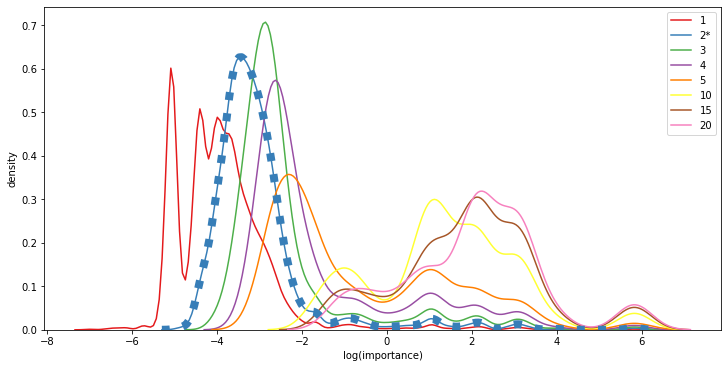

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1, cutoff_list=[1, 2, 3, 4, 5, 10, 15, 20], find_automatic_best=True)
plt.show()

Histogram of log importances

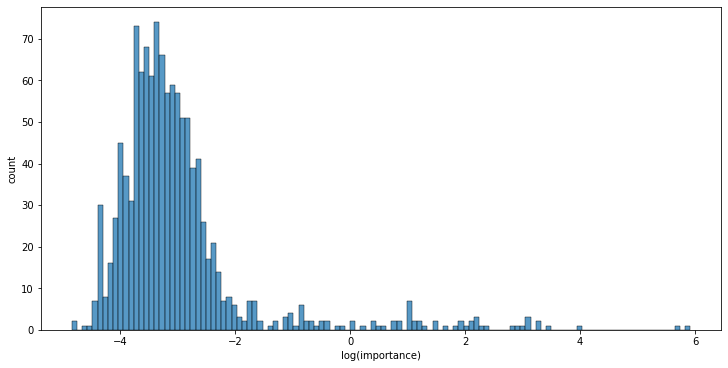

In [10]:
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, split_count=2)
plt.show()

p-value and FDR calculation

In [11]:
pvalsDF, fdr = fdrCalc.compute_fdr(countThreshold = 2, local_fdr_cutoff = 0.05)
pvalsDF, fdr

(                           variant_id  logImportance        pvalue  \
 0     15_66308697_ACATGGTTCAATGAATT_A      -4.846209  9.985872e-01   
 1                    15_66438791_AC_A      -4.814520  9.982421e-01   
 2                     15_66300869_C_T      -4.612724  9.936681e-01   
 3                     5_126644681_G_A      -4.540632  9.904355e-01   
 4                     15_75026627_C_A      -4.482650  9.868964e-01   
 ...                               ...            ...           ...   
 1156                  5_126626044_A_C       3.251120  3.330669e-16   
 1157                  5_126630016_C_T       3.418323  0.000000e+00   
 1158                  2_223034082_A_G       3.955555  0.000000e+00   
 1159                            label       5.730820  0.000000e+00   
 1160                            score       5.918587  0.000000e+00   
 
       is_significant  
 0              False  
 1              False  
 2              False  
 3              False  
 4              False  
 .

FDR Plot

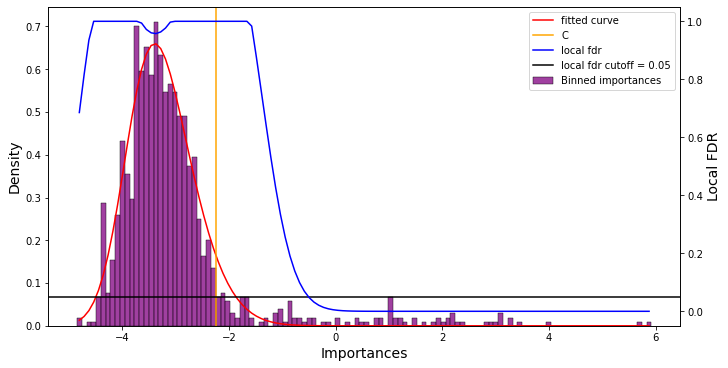

In [12]:
fig, ax3 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot(ax3)
plt.show()

Manhattan plot of negative log p-values

/home/edw222/anaconda3/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


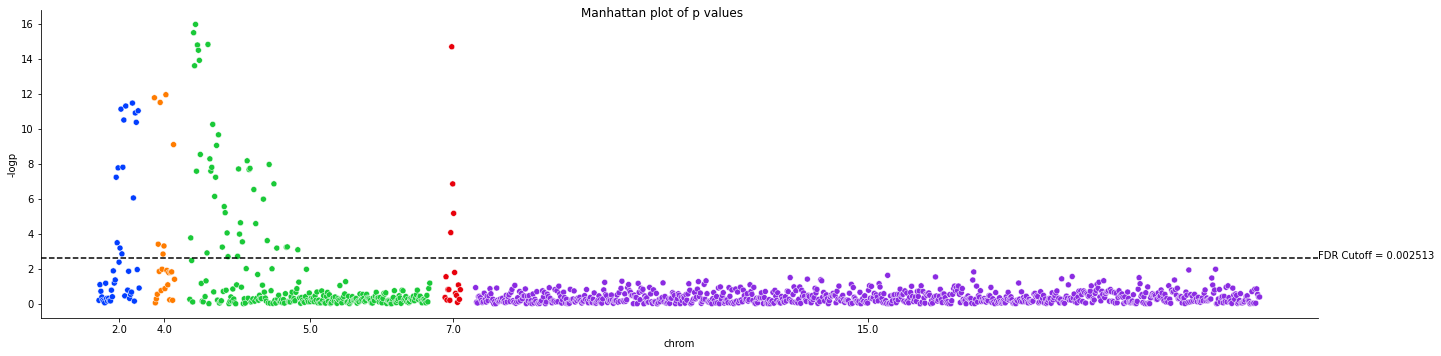

In [13]:
manhattan_df = fdrCalc.plot_manhattan_imp(fdr=fdr)
# Not sure how to project the significance line
# I have taken the negative log of the calculated fdr in this example. Have also tried the local_fdr_cutoff but it doesn't look correct.